- Apply latent optimization on DCGAN
- GD, NGD

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import random
import glob

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input, Reshape, Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

tf.random.set_seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [3]:
def ConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2D(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation(leakyrelu)(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

def deConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2DTranspose(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation('relu')(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

def lo_gd(G, D, z, alpha=1):
    with tf.GradientTape() as tape:
        tape.watch(z)
        f_z = D(G(z))
        
    fz_dz = tape.gradient(f_z, z)
    
    dz = alpha * fz_dz
    z_p = tf.clip_by_value(z+dz, -1, 1)
    return z_p

def lo_ngd(G, D, z, alpha=0.9, beta=1., norm=300):
    with tf.GradientTape() as tape:
        tape.watch(z)
        f_z = D(G(z))
        
    fz_dz = tape.gradient(f_z, z)
    dz = alpha / (beta + tf.norm(fz_dz, ord=2)) * fz_dz / norm
    z_p = tf.clip_by_value(z+dz, -1, 1) 
    
    return z_p

In [4]:
class DCGAN(keras.Model):
    def __init__(self, x_dim, z_dim, is_ngd=True): 
        super(DCGAN, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.is_ngd = is_ngd

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
    def compile(self, g_optim, d_optim, loss_fn):
        super(DCGAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.loss_fn = loss_fn
        
    def build_generator(self): 
        inputs = Input(shape = self.z_dim)
        
        x = Dense(128*7*7, activation='relu')(inputs)
        x = Reshape((7, 7, 128))(x) # 7, ,7 128
        x = BatchNormalization(momentum=0.8)(x)
        x = deConvBlock(64)(x) # 14, 14, 64
        x = deConvBlock(32)(x) # 28, 28, 32
        
        outputs = Conv2D(1, kernel_size=3, strides=1, activation='tanh', padding='same')(x) # 28, 28, 1
        return Model(inputs, outputs, name='generator')

    def build_discriminator(self):
        inputs = Input(shape = self.x_dim)
        
        x = ConvBlock(16)(inputs)
        x = ConvBlock(32)(x)
        x = ConvBlock(64)(x)
        x = Flatten()(x)
        
        outputs = Dense(1)(x)
        return Model(inputs, outputs, name='discriminator')
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]
        
        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([real_labels, fake_labels], 0)
        
        noise = tf.random.uniform((batch_size, self.z_dim), -1, 1)
        if self.is_ngd:
            noise = lo_ngd(self.generator, self.discriminator, noise)
        else:
            noise = lo_gd(self.generator, self.discriminator, noise)
        
        # discriminator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            all_x = tf.concat([x, fake], 0)
            preds = self.discriminator(all_x)
            
            d_loss = self.loss_fn(labels, preds)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generator
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            preds = self.discriminator(fake)

            g_loss = self.loss_fn(real_labels, preds)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}

In [5]:
class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            r, c = 2, 5
            noise = np.random.normal(0, 1, (r*c, 100))
            imgs = self.model.generator.predict(noise)*0.5 +0.5
            imgs = imgs.reshape(r*c, 28, 28)
            fig, axs = plt.subplots(r, c)
            n = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(imgs[n], cmap='gray')
                    axs[i,j].axis('off')
                    n += 1
            plt.show()
            plt.close()

In [6]:
# prepare data
from tensorflow.keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = np.expand_dims(train_X, -1)


In [7]:
shape = train_X.shape[1:]
gan = DCGAN(shape, 100)

In [8]:
gan.generator.summary()
gan.discriminator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        73792     
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        25

In [9]:
gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    losses.BinaryCrossentropy(from_logits=True), 
         )

Epoch 1/101
1872/1875 [============================>.] - ETA: 0s - d_loss: 0.5341 - g_loss: 1.1830

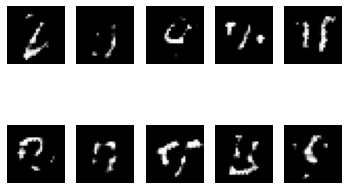

1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.5342 - g_loss: 1.1823
Epoch 2/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6293 - g_loss: 0.8529
Epoch 3/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6446 - g_loss: 0.8239
Epoch 4/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6512 - g_loss: 0.8174
Epoch 5/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6501 - g_loss: 0.8159
Epoch 6/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6523 - g_loss: 0.8141
Epoch 7/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6581 - g_loss: 0.8097
Epoch 8/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6626 - g_loss: 0.8034
Epoch 9/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6642 - g_loss: 0.7975
Epoch 10/101
1875/1875 [==============================] - 25s 13ms/

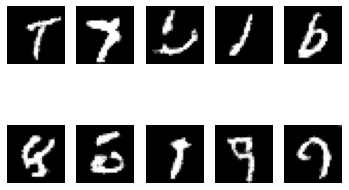

1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6683 - g_loss: 0.7869
Epoch 12/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6696 - g_loss: 0.7829
Epoch 13/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6712 - g_loss: 0.7810
Epoch 14/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6717 - g_loss: 0.77560s - d_loss: 0.671
Epoch 15/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6727 - g_loss: 0.7761
Epoch 16/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6730 - g_loss: 0.7754
Epoch 17/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6749 - g_loss: 0.7689
Epoch 18/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6751 - g_loss: 0.7708
Epoch 19/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6760 - g_loss: 0.7673
Epoch 20/101
1875/1875 [=================

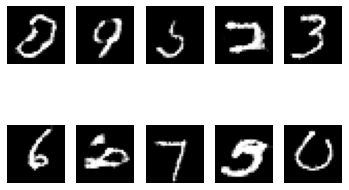

1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6770 - g_loss: 0.7619
Epoch 22/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6780 - g_loss: 0.7600
Epoch 23/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6774 - g_loss: 0.7600
Epoch 24/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6785 - g_loss: 0.7577
Epoch 25/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6783 - g_loss: 0.7573
Epoch 26/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6786 - g_loss: 0.7563
Epoch 27/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6783 - g_loss: 0.7554
Epoch 28/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6794 - g_loss: 0.7536
Epoch 29/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6802 - g_loss: 0.7513
Epoch 30/101
1875/1875 [==============================] - 1

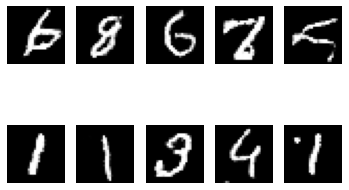

1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6802 - g_loss: 0.7504
Epoch 32/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6805 - g_loss: 0.7495
Epoch 33/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6810 - g_loss: 0.7482
Epoch 34/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6816 - g_loss: 0.7467
Epoch 35/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6810 - g_loss: 0.7475
Epoch 36/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6810 - g_loss: 0.7475
Epoch 37/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6815 - g_loss: 0.7458
Epoch 38/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6817 - g_loss: 0.7441
Epoch 39/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6818 - g_loss: 0.7442
Epoch 40/101
1875/1875 [==============================] - 2

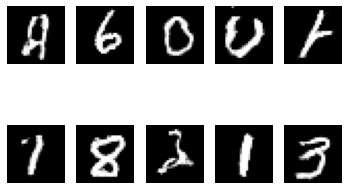

1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6825 - g_loss: 0.7424
Epoch 42/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6822 - g_loss: 0.7425
Epoch 43/101
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6822 - g_loss: 0.7426
Epoch 44/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6824 - g_loss: 0.7420
Epoch 45/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6821 - g_loss: 0.7413
Epoch 46/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6826 - g_loss: 0.7410
Epoch 47/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6822 - g_loss: 0.7418
Epoch 48/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6826 - g_loss: 0.7409
Epoch 49/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6828 - g_loss: 0.7412
Epoch 50/101
1875/1875 [==============================] - 2

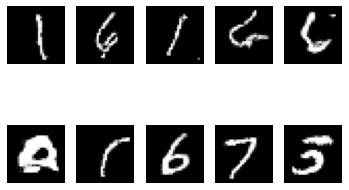

1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6826 - g_loss: 0.7406
Epoch 52/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6827 - g_loss: 0.7406
Epoch 53/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6827 - g_loss: 0.7404
Epoch 54/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6827 - g_loss: 0.7404
Epoch 55/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6821 - g_loss: 0.7421
Epoch 56/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6830 - g_loss: 0.7396
Epoch 57/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6829 - g_loss: 0.7401
Epoch 58/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6824 - g_loss: 0.7409
Epoch 59/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6828 - g_loss: 0.7401
Epoch 60/101
1875/1875 [==============================] - 1

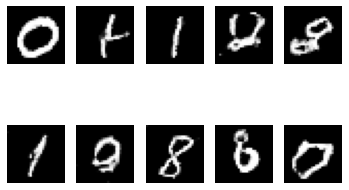

1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6827 - g_loss: 0.7403
Epoch 62/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6829 - g_loss: 0.7401
Epoch 63/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6827 - g_loss: 0.7400
Epoch 64/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6828 - g_loss: 0.7403
Epoch 65/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6830 - g_loss: 0.7393
Epoch 66/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6826 - g_loss: 0.7408
Epoch 67/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6825 - g_loss: 0.7405
Epoch 68/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6826 - g_loss: 0.7402
Epoch 69/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6826 - g_loss: 0.7407
Epoch 70/101
1875/1875 [==============================] - 2

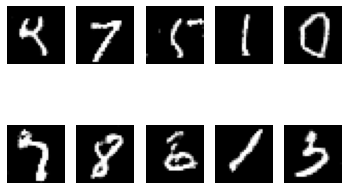

1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6825 - g_loss: 0.7410
Epoch 72/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6827 - g_loss: 0.7403
Epoch 73/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6827 - g_loss: 0.7412
Epoch 74/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6823 - g_loss: 0.7406
Epoch 75/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6821 - g_loss: 0.7415
Epoch 76/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6826 - g_loss: 0.7411
Epoch 77/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6824 - g_loss: 0.7414
Epoch 78/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6820 - g_loss: 0.7421
Epoch 79/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6823 - g_loss: 0.7418
Epoch 80/101
1875/1875 [==============================] - 2

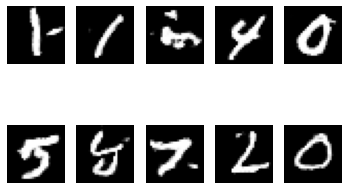

1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6818 - g_loss: 0.7426
Epoch 82/101
1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6822 - g_loss: 0.7426
Epoch 83/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6816 - g_loss: 0.7434
Epoch 84/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6821 - g_loss: 0.7431
Epoch 85/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6816 - g_loss: 0.7429
Epoch 86/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6817 - g_loss: 0.7441
Epoch 87/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6821 - g_loss: 0.7431
Epoch 88/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6817 - g_loss: 0.7443
Epoch 89/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6817 - g_loss: 0.7441
Epoch 90/101
1875/1875 [==============================] - 2

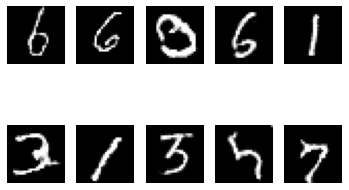

1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6814 - g_loss: 0.7450
Epoch 92/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6816 - g_loss: 0.7443
Epoch 93/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6818 - g_loss: 0.7439
Epoch 94/101
1875/1875 [==============================] - 25s 14ms/step - d_loss: 0.6818 - g_loss: 0.7443
Epoch 95/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6815 - g_loss: 0.7445
Epoch 96/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6816 - g_loss: 0.7446
Epoch 97/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6816 - g_loss: 0.7446
Epoch 98/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6815 - g_loss: 0.7449
Epoch 99/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6815 - g_loss: 0.7456
Epoch 100/101
1875/1875 [==============================] - 

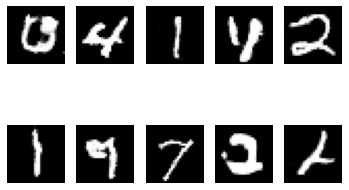

1875/1875 [==============================] - 26s 14ms/step - d_loss: 0.6813 - g_loss: 0.7456


In [10]:
gan.fit(train_X,
       epochs=101,
       shuffle=True,
       callbacks=[PlotCallback()],
       batch_size=32)

Epoch 1/101
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.4764 - g_loss: 1.2961

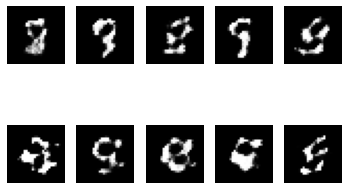

1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.4765 - g_loss: 1.2957
Epoch 2/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.4881 - g_loss: 1.2639
Epoch 3/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.5461 - g_loss: 1.1424
Epoch 4/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.5978 - g_loss: 1.0034
Epoch 5/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6208 - g_loss: 0.9436
Epoch 6/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6236 - g_loss: 0.9393
Epoch 7/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6336 - g_loss: 0.9193
Epoch 8/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6383 - g_loss: 0.9140
Epoch 9/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6432 - g_loss: 0.8966
Epoch 10/101
1875/1875 [==============================] - 19s 10ms/

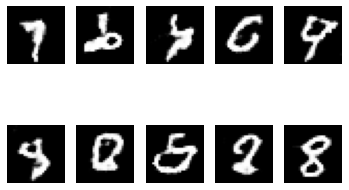

1875/1875 [==============================] - 20s 10ms/step - d_loss: 0.6359 - g_loss: 0.9121
Epoch 12/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6303 - g_loss: 0.9223
Epoch 13/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6363 - g_loss: 0.8950
Epoch 14/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6363 - g_loss: 0.9026
Epoch 15/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6395 - g_loss: 0.8869
Epoch 16/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6401 - g_loss: 0.8831
Epoch 17/101
1875/1875 [==============================] - 20s 10ms/step - d_loss: 0.6399 - g_loss: 0.8804
Epoch 18/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6397 - g_loss: 0.8836
Epoch 19/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6439 - g_loss: 0.8721
Epoch 20/101
1875/1875 [==============================] - 2

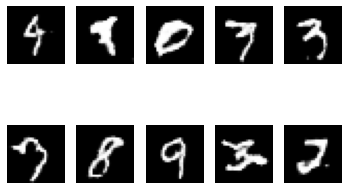

1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6479 - g_loss: 0.8565
Epoch 22/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6462 - g_loss: 0.8602
Epoch 23/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6508 - g_loss: 0.8479
Epoch 24/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6513 - g_loss: 0.8478
Epoch 25/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6448 - g_loss: 0.8612
Epoch 26/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6482 - g_loss: 0.8483
Epoch 27/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6505 - g_loss: 0.8462
Epoch 28/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6520 - g_loss: 0.8439
Epoch 29/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6524 - g_loss: 0.8375
Epoch 30/101
1875/1875 [==============================] - 2

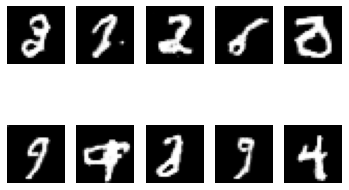

1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6524 - g_loss: 0.8373
Epoch 32/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6567 - g_loss: 0.8278
Epoch 33/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6552 - g_loss: 0.8268
Epoch 34/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6530 - g_loss: 0.8371
Epoch 35/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6550 - g_loss: 0.8266
Epoch 36/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6583 - g_loss: 0.8188
Epoch 37/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6546 - g_loss: 0.8314
Epoch 38/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6571 - g_loss: 0.8186
Epoch 39/101
1875/1875 [==============================] - 23s 13ms/step - d_loss: 0.6623 - g_loss: 0.8062
Epoch 40/101
1875/1875 [==============================] - 2

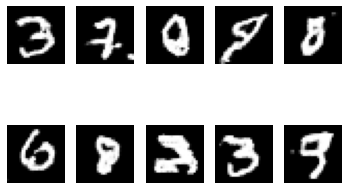

1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6573 - g_loss: 0.8199
Epoch 42/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6607 - g_loss: 0.8097
Epoch 43/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6653 - g_loss: 0.7971
Epoch 44/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6624 - g_loss: 0.8039
Epoch 45/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6610 - g_loss: 0.8083
Epoch 46/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6609 - g_loss: 0.8054
Epoch 47/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6594 - g_loss: 0.8137
Epoch 48/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6636 - g_loss: 0.7993
Epoch 49/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6593 - g_loss: 0.8085
Epoch 50/101
1875/1875 [==============================] - 2

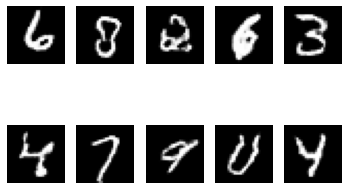

1875/1875 [==============================] - 22s 11ms/step - d_loss: 0.6624 - g_loss: 0.8023
Epoch 52/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6622 - g_loss: 0.8029
Epoch 53/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6626 - g_loss: 0.8000
Epoch 54/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6601 - g_loss: 0.8083
Epoch 55/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6598 - g_loss: 0.8065
Epoch 56/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6614 - g_loss: 0.8051
Epoch 57/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6629 - g_loss: 0.8007
Epoch 58/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6669 - g_loss: 0.7921
Epoch 59/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6610 - g_loss: 0.8027
Epoch 60/101
1875/1875 [==============================] - 2

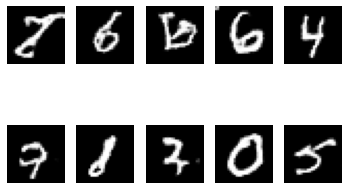

1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6582 - g_loss: 0.8116
Epoch 62/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6627 - g_loss: 0.8005
Epoch 63/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6646 - g_loss: 0.7959
Epoch 64/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6677 - g_loss: 0.7875
Epoch 65/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6663 - g_loss: 0.7923
Epoch 66/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6627 - g_loss: 0.7989
Epoch 67/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6650 - g_loss: 0.7951
Epoch 68/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6658 - g_loss: 0.7910
Epoch 69/101
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6686 - g_loss: 0.7844
Epoch 70/101
1875/1875 [==============================] - 2

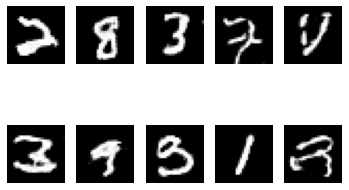

1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6696 - g_loss: 0.7817
Epoch 72/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6709 - g_loss: 0.7779
Epoch 73/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6681 - g_loss: 0.7857
Epoch 74/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6701 - g_loss: 0.7805
Epoch 75/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6689 - g_loss: 0.7819
Epoch 76/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6717 - g_loss: 0.7752
Epoch 77/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6667 - g_loss: 0.7861
Epoch 78/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6661 - g_loss: 0.7894
Epoch 79/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6696 - g_loss: 0.7807
Epoch 80/101
1875/1875 [==============================] - 2

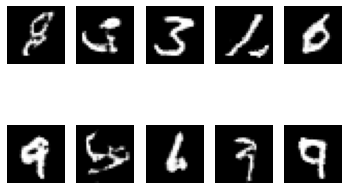

1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6681 - g_loss: 0.7830
Epoch 82/101
1875/1875 [==============================] - 24s 13ms/step - d_loss: 0.6670 - g_loss: 0.7875
Epoch 83/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6688 - g_loss: 0.7838
Epoch 84/101
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6698 - g_loss: 0.7787
Epoch 85/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6719 - g_loss: 0.7752
Epoch 86/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6718 - g_loss: 0.7738
Epoch 87/101
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6715 - g_loss: 0.7731
Epoch 88/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6699 - g_loss: 0.7782
Epoch 89/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6710 - g_loss: 0.7772
Epoch 90/101
1875/1875 [==============================] - 2

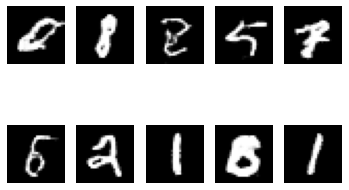

1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6676 - g_loss: 0.7823
Epoch 92/101
1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6686 - g_loss: 0.7809
Epoch 93/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6706 - g_loss: 0.7770
Epoch 94/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6679 - g_loss: 0.7805
Epoch 95/101
1875/1875 [==============================] - 23s 12ms/step - d_loss: 0.6709 - g_loss: 0.7764
Epoch 96/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6693 - g_loss: 0.7792
Epoch 97/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6686 - g_loss: 0.7819
Epoch 98/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6703 - g_loss: 0.7760
Epoch 99/101
1875/1875 [==============================] - 22s 12ms/step - d_loss: 0.6715 - g_loss: 0.7752
Epoch 100/101
1875/1875 [==============================] - 

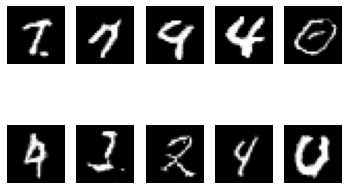

1875/1875 [==============================] - 21s 11ms/step - d_loss: 0.6683 - g_loss: 0.7807


In [11]:
shape = train_X.shape[1:]
gan = DCGAN(shape, 100, is_ngd=False)

gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    losses.BinaryCrossentropy(from_logits=True), 
         )

gan.fit(train_X,
       epochs=101,
       shuffle=True,
       callbacks=[PlotCallback()],
       batch_size=32)